In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.svm import SVR
import math
from math import floor,ceil,sqrt
import datetime as dt

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, max_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from itertools import cycle

import os
for dirname, _, filenames in os.walk('/content/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Text(0.5, 1.0, 'Stock Price of Google over the Years')

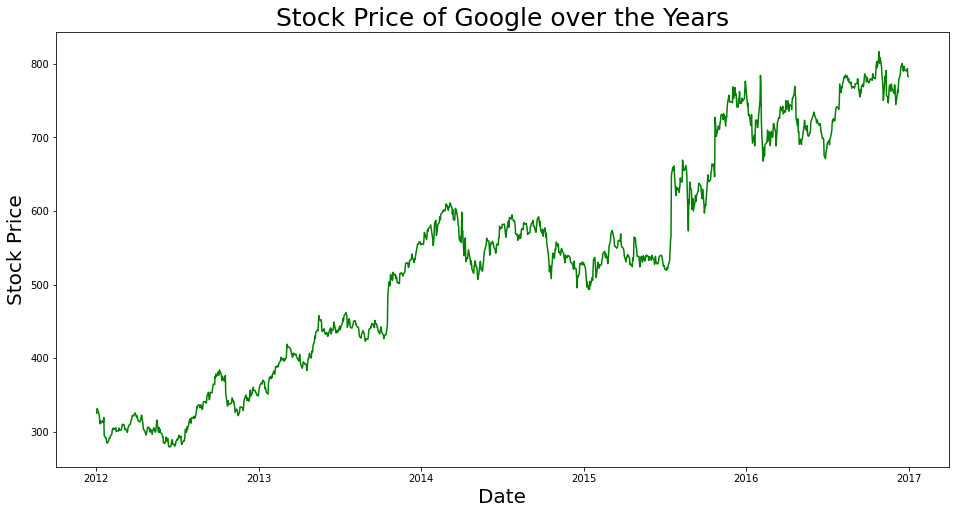

In [2]:
data = pd.read_csv('/content/Google_Training.csv',sep=",")
data['Date'] = pd.to_datetime(data.Date,format='%m/%d/%Y')
data.index = data['Date']
plt.figure(figsize=(16,8))
plt.plot(data['Open'], label='Open Price history',color='g')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Google over the Years',size=25)

In [3]:
datas = data.loc[:,["Open"]].values

train = datas[:len(data)-50] 
test = datas[len(train):]

train=train.reshape(train.shape[0],1)

In [4]:
opendf = data[['Date','Open']]

In [5]:
open_stock = opendf.copy()
del opendf['Date']

In [6]:
# feature scalling
scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler
train_scaled = scaler.fit_transform(train) # applying to Scaler to train

### CREATE DATASET FOR RNN & LSTM / DEEP LEARNING

In [7]:
X_train = []
y_train = []
timesteps = 50

for i in range(timesteps, train_scaled.shape[0]):
    X_train.append(train_scaled[i-timesteps:i,0])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)


# Reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 

In [8]:
inputs = datas[len(datas) - len(test) - timesteps:]
inputs = scaler.transform(inputs)  

In [9]:
X_test = []
y_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i, 0])
    y_test.append(inputs[i,0]) 
X_test,y_test = np.array(X_test),np.array(y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### **RNN**

In [10]:
print(X_train.shape)
print(X_test.shape)

(1158, 50, 1)
(50, 50, 1)


In [11]:
# --- RNN ---

# Importing the Keras libraries and packages
tf.keras.backend.clear_session()
from keras.models import Sequential  
from keras.layers import Dense 
from keras.layers import SimpleRNN
from keras.layers import Dropout # it block to overfitting 

# Initialising the RNN
regressor = Sequential()

# Adding the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(1))

# Compiling the RNN
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

In [12]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train,validation_data=(X_test, y_test), epochs = 50, batch_size = 128)

Epoch 1/50
10/10 [==============================] - 5s 136ms/step - loss: 0.7435 - val_loss: 0.3467
Epoch 2/50
10/10 [==============================] - 1s 81ms/step - loss: 0.3642 - val_loss: 0.0320
Epoch 3/50
10/10 [==============================] - 1s 80ms/step - loss: 0.3062 - val_loss: 0.0029
Epoch 4/50
10/10 [==============================] - 1s 78ms/step - loss: 0.3510 - val_loss: 0.0618
Epoch 5/50
10/10 [==============================] - 1s 78ms/step - loss: 0.2425 - val_loss: 0.0240
Epoch 6/50
10/10 [==============================] - 1s 77ms/step - loss: 0.2694 - val_loss: 0.2390
Epoch 7/50
10/10 [==============================] - 1s 78ms/step - loss: 0.2530 - val_loss: 0.0065
Epoch 8/50
10/10 [==============================] - 1s 78ms/step - loss: 0.2033 - val_loss: 0.0391
Epoch 9/50
10/10 [==============================] - 1s 78ms/step - loss: 0.1900 - val_loss: 0.3322
Epoch 10/50
10/10 [==============================] - 1s 78ms/step - loss: 0.1674 - val_loss: 0.1162
Epoch 11

In [13]:
rnn1_train_predict=regressor.predict(X_train)
rnn1_test_predict=regressor.predict(X_test)
rnn1_train_predict.shape, rnn1_test_predict.shape

((1158, 1), (50, 1))

In [14]:
# Transform back to original form
rnn1_train_predict = scaler.inverse_transform(rnn1_train_predict)
rnn1_test_predict = scaler.inverse_transform(rnn1_test_predict)
original_rnn1_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_rnn1_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [15]:
# Evaluation
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_rnn1_ytrain,rnn1_train_predict)))
print("Train data MSE: ", mean_squared_error(original_rnn1_ytrain,rnn1_train_predict))
print("Test data MAE: ", mean_absolute_error(original_rnn1_ytrain,rnn1_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_rnn1_ytest,rnn1_test_predict)))
print("Test data MSE: ", mean_squared_error(original_rnn1_ytest,rnn1_test_predict))
print("Test data MAE: ", mean_absolute_error(original_rnn1_ytest,rnn1_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_rnn1_ytrain, rnn1_train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_rnn1_ytest, rnn1_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_rnn1_ytrain, rnn1_train_predict))
print("Test data R2 score:", r2_score(original_rnn1_ytest, rnn1_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data MGD: ", mean_gamma_deviance(original_rnn1_ytrain, rnn1_train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_rnn1_ytest, rnn1_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_rnn1_ytrain, rnn1_train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_rnn1_ytest, rnn1_test_predict))

Train data RMSE:  18.632880085221597
Train data MSE:  347.1842202702475
Test data MAE:  12.61794216966382
-------------------------------------------------------------------------------------
Test data RMSE:  44.24506629691438
Test data MSE:  1957.6258916183488
Test data MAE:  42.73942651367187
-------------------------------------------------------------------------------------
Train data explained variance regression score: 0.9872474871138025
Test data explained variance regression score: 0.5884083025867827
-------------------------------------------------------------------------------------
Train data R2 score: 0.9827658378622088
Test data R2 score: -5.152241698977377
-------------------------------------------------------------------------------------
Train data MGD:  0.0008191803565654174
Test data MGD:  0.0034525216195774354
----------------------------------------------------------------------
Train data MPD:  0.52352623989178
Test data MPD:  2.5990449051317728


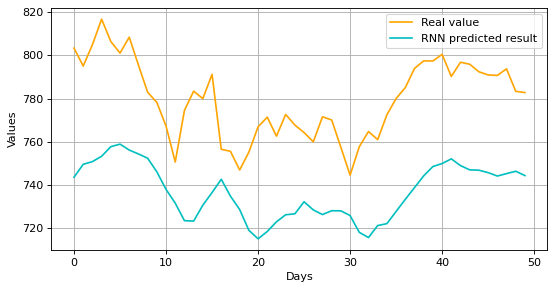

In [16]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="orange",label="Real value")
plt.plot(rnn1_test_predict,color="c",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

### **RNN Modified**

In [17]:
# RNN Modified
tf.keras.backend.clear_session()
from keras.models import Sequential  
from keras.layers import Dense 
from keras.layers import SimpleRNN
from keras.layers import Dropout 
from keras.layers import Flatten

# Initialising the RNN
regressor = Sequential()

regressor.add(SimpleRNN(units = 50,activation='relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,activation='tanh',return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,activation='tanh'))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1)) 

# Compiling the RNN
regressor.compile(optimizer = 'rmsprop', loss='mean_squared_error')

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 100)           10200     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            7550      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [18]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=50, batch_size = 8)

Epoch 1/50
145/145 [==============================] - 7s 33ms/step - loss: 0.0367 - val_loss: 9.2035e-04
Epoch 2/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0124 - val_loss: 0.0076
Epoch 3/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0094 - val_loss: 0.0019
Epoch 4/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0076 - val_loss: 0.0011
Epoch 5/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0067 - val_loss: 0.0105
Epoch 6/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0061 - val_loss: 0.0163
Epoch 7/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 8/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0050 - val_loss: 0.0243
Epoch 9/50
145/145 [==============================] - 5s 36ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 10/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0050 - va

In [19]:
rnn2_train_predict=regressor.predict(X_train)
rnn2_test_predict=regressor.predict(X_test)
rnn2_train_predict.shape, rnn2_test_predict.shape

((1158, 1), (50, 1))

In [20]:
# Transform back to original form
rnn2_train_predict = scaler.inverse_transform(rnn2_train_predict)
rnn2_test_predict = scaler.inverse_transform(rnn2_test_predict)
original_rnn2_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_rnn2_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [21]:
# Evaluation
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_rnn2_ytrain,rnn2_train_predict)))
print("Train data MSE: ", mean_squared_error(original_rnn2_ytrain,rnn2_train_predict))
print("Test data MAE: ", mean_absolute_error(original_rnn2_ytrain,rnn2_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_rnn2_ytest,rnn2_test_predict)))
print("Test data MSE: ", mean_squared_error(original_rnn2_ytest,rnn2_test_predict))
print("Test data MAE: ", mean_absolute_error(original_rnn2_ytest,rnn2_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_rnn2_ytrain, rnn2_train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_rnn2_ytest, rnn2_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_rnn2_ytrain, rnn2_train_predict))
print("Test data R2 score:", r2_score(original_rnn2_ytest, rnn2_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data MGD: ", mean_gamma_deviance(original_rnn2_ytrain, rnn2_train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_rnn2_ytest, rnn2_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_rnn2_ytrain, rnn2_train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_rnn2_ytest, rnn2_test_predict))

Train data RMSE:  19.91707913727105
Train data MSE:  396.6900413603177
Test data MAE:  15.099448309652956
-------------------------------------------------------------------------------------
Test data RMSE:  38.25397634374719
Test data MSE:  1463.3667061079695
Test data MAE:  36.87526879882813
-------------------------------------------------------------------------------------
Train data explained variance regression score: 0.9892290891645209
Test data explained variance regression score: 0.6744746112994404
-------------------------------------------------------------------------------------
Train data R2 score: 0.9803083778233666
Test data R2 score: -3.598930627531673
-------------------------------------------------------------------------------------
Train data MGD:  0.0010382805410479809
Test data MGD:  0.002549732311735635
----------------------------------------------------------------------
Train data MPD:  0.6305058444388693
Test data MPD:  1.9311441430211471


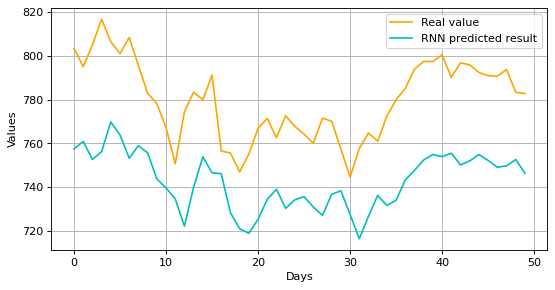

In [22]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="orange",label="Real value")
plt.plot(rnn2_test_predict,color="c",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

In [23]:
# shift train predictions for plotting

look_back=timesteps
rnn1_trainPredictPlot = np.empty_like(opendf)
rnn1_trainPredictPlot[:, :] = np.nan
rnn1_trainPredictPlot[look_back:len(rnn1_train_predict)+look_back, :] = rnn1_train_predict
print("Train predicted data: ", rnn1_trainPredictPlot.shape)

# shift test predictions for plotting
rnn1_testPredictPlot = np.empty_like(opendf)
rnn1_testPredictPlot[:, :] = np.nan
rnn1_testPredictPlot[len(rnn1_train_predict)+(look_back):len(opendf), :] = rnn1_test_predict
print("Test predicted data: ", rnn1_testPredictPlot.shape)

print("-------------------------------------------------------------------------------------")

rnn2_trainPredictPlot = np.empty_like(opendf)
rnn2_trainPredictPlot[:, :] = np.nan
rnn2_trainPredictPlot[look_back:len(rnn2_train_predict)+look_back, :] = rnn2_train_predict
print("Train predicted data: ", rnn2_trainPredictPlot.shape)

# shift test predictions for plotting
rnn2_testPredictPlot = np.empty_like(opendf)
rnn2_testPredictPlot[:, :] = np.nan
rnn2_testPredictPlot[len(rnn2_train_predict)+(look_back):len(opendf), :] = rnn2_test_predict

print("Test predicted data: ", rnn2_testPredictPlot.shape)

names = cycle(['Original open price','Train RNN1 predicted open price','Test RNN1 predicted open price','Train RNN2 predicted open price','Test RNN2 predicted open price'])


plotdf = pd.DataFrame({'date': open_stock['Date'],
                       'original_open': open_stock['Open'],
                      'rnn1_train_predicted_open': rnn1_trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'rnn1_test_predicted_open': rnn1_testPredictPlot.reshape(1,-1)[0].tolist(),
                       'rnn2_train_predicted_open': rnn2_trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'rnn2_test_predicted_open': rnn2_testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_open'],plotdf['rnn1_train_predicted_open'],
                                          plotdf['rnn1_test_predicted_open'],plotdf['rnn2_train_predicted_open'],
                                          plotdf['rnn2_test_predicted_open']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Open Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1258, 1)
Test predicted data:  (1258, 1)
-------------------------------------------------------------------------------------
Train predicted data:  (1258, 1)
Test predicted data:  (1258, 1)


In [24]:
predicted_data_modified = regressor.predict(X_test)
predicted_data_modified = scaler.inverse_transform(predicted_data_modified)

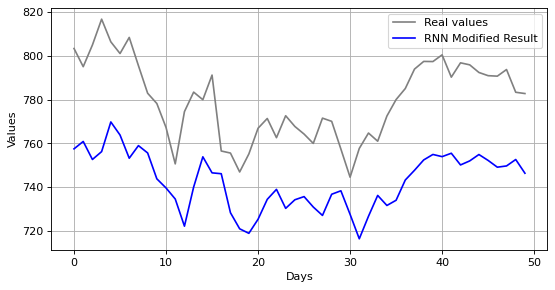

In [25]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="gray",label="Real values")
# plt.plot(predicted_data,color="cyan",label="RNN result")
plt.plot(predicted_data_modified,color="blue",label="RNN Modified Result")

plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

### **LSTM**

In [26]:
print(X_train.shape)
print(X_test.shape)

(1158, 50, 1)
(50, 50, 1)


In [27]:
## --- LSTM ----
from keras.models import Sequential  
from keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(5, input_shape=(None,1))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1)

Epoch 1/100
1158/1158 [==============================] - 12s 9ms/step - loss: 0.0022 - val_loss: 8.2538e-04
Epoch 2/100
1158/1158 [==============================] - 10s 8ms/step - loss: 7.9201e-04 - val_loss: 0.0015
Epoch 3/100
1158/1158 [==============================] - 10s 9ms/step - loss: 6.8673e-04 - val_loss: 5.6745e-04
Epoch 4/100
1158/1158 [==============================] - 10s 8ms/step - loss: 6.3350e-04 - val_loss: 5.7346e-04
Epoch 5/100
1158/1158 [==============================] - 10s 8ms/step - loss: 5.7517e-04 - val_loss: 4.9057e-04
Epoch 6/100
1158/1158 [==============================] - 10s 8ms/step - loss: 5.1554e-04 - val_loss: 9.6178e-04
Epoch 7/100
1158/1158 [==============================] - 10s 8ms/step - loss: 4.7152e-04 - val_loss: 4.4098e-04
Epoch 8/100
1158/1158 [==============================] - 10s 8ms/step - loss: 4.5008e-04 - val_loss: 4.2658e-04
Epoch 9/100
1158/1158 [==============================] - 10s 8ms/step - loss: 4.1515e-04 - val_loss: 4.3697e-04


In [ ]:
lstm_train_predict=model.predict(X_train)
lstm_test_predict=model.predict(X_test)
lstm_train_predict.shape, lstm_test_predict.shape

In [ ]:
# Transform back to original form
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)
original_lstm_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_lstm_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_lstm_ytrain,lstm_train_predict)))
print("Train data MSE: ", mean_squared_error(original_lstm_ytrain,lstm_train_predict))
print("Test data MAE: ", mean_absolute_error(original_lstm_ytrain,lstm_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_lstm_ytest,lstm_test_predict)))
print("Test data MSE: ", mean_squared_error(original_lstm_ytest,lstm_test_predict))
print("Test data MAE: ", mean_absolute_error(original_lstm_ytest,lstm_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_lstm_ytrain, lstm_train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_lstm_ytest, lstm_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_lstm_ytrain, lstm_train_predict))
print("Test data R2 score:", r2_score(original_lstm_ytest, lstm_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data MGD: ", mean_gamma_deviance(original_lstm_ytrain, lstm_train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_lstm_ytest, lstm_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_lstm_ytrain, lstm_train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_lstm_ytest, lstm_test_predict))

In [ ]:
predicted_data2=model.predict(X_test)
predicted_data2=scaler.inverse_transform(predicted_data2)

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="orange",label="Real value")
plt.plot(predicted_data2,color="c",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test, linestyle='dashed', color="orange",label="Real value")
# plt.plot(predicted_data,color="LimeGreen",label="RNN predicted result")
plt.plot(lstm_test_predict,color="Gold",label="LSTM predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

In [ ]:
# shift train predictions for plotting

look_back=timesteps
trainPredictPlot = np.empty_like(opendf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(lstm_train_predict)+look_back, :] = lstm_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(opendf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(lstm_train_predict)+(look_back):len(opendf), :] = lstm_test_predict

print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original open price','Train predicted open price','Test predicted open price'])


plotdf = pd.DataFrame({'date': open_stock['Date'],
                       'original_open': open_stock['Open'],
                      'train_predicted_open': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_open': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_open'],plotdf['train_predicted_open'],
                                          plotdf['test_predicted_open']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Open Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### **SVR**

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]) 

In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel= 'rbf', C= 1e2, gamma= 0.1, degree=2,verbose=True)
svr.fit(X_train, y_train)

In [ ]:
svr_train_predict=svr.predict(X_train)
svr_test_predict=svr.predict(X_test)
svr_train_predict = svr_train_predict.reshape(-1,1)
svr_test_predict = svr_test_predict.reshape(-1,1)
svr_train_predict.shape, svr_test_predict.shape

In [ ]:
# Transform back to original form

svr_train_predict = scaler.inverse_transform(svr_train_predict)
svr_test_predict = scaler.inverse_transform(svr_test_predict)
original_svr_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_svr_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_svr_ytrain,svr_train_predict)))
print("Train data MSE: ", mean_squared_error(original_svr_ytrain,svr_train_predict))
print("Test data MAE: ", mean_absolute_error(original_svr_ytrain,svr_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_svr_ytest,svr_test_predict)))
print("Test data MSE: ", mean_squared_error(original_svr_ytest,svr_test_predict))
print("Test data MAE: ", mean_absolute_error(original_svr_ytest,svr_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_svr_ytrain, svr_train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_svr_ytest, svr_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_svr_ytrain, svr_train_predict))
print("Test data R2 score:", r2_score(original_svr_ytest, svr_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data MGD: ", mean_gamma_deviance(original_svr_ytrain, svr_train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_svr_ytest, svr_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_svr_ytrain, svr_train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_svr_ytest, svr_test_predict))

In [ ]:
# shift train predictions for plotting

look_back=timesteps
trainPredictPlot = np.empty_like(opendf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(svr_train_predict)+look_back, :] = svr_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(opendf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(svr_train_predict)+(look_back):len(opendf), :] = svr_test_predict

print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original open price','Train predicted open price','Test predicted open price'])


plotdf = pd.DataFrame({'date': open_stock['Date'],
                       'original_open': open_stock['Open'],
                      'train_predicted_open': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_open': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_open'],plotdf['train_predicted_open'],
                                          plotdf['test_predicted_open']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Open Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### **KNN**

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]) 

In [ ]:
from sklearn import neighbors

K = int(timesteps/2)
neighbor = neighbors.KNeighborsRegressor(n_neighbors = K, leaf_size=5)
neighbor.fit(X_train, y_train)

In [ ]:
knn_train_predict=neighbor.predict(X_train)
knn_test_predict=neighbor.predict(X_test)
knn_train_predict = knn_train_predict.reshape(-1,1)
knn_test_predict = knn_test_predict.reshape(-1,1)
knn_train_predict.shape, knn_test_predict.shape

In [ ]:
# Transform back to original form

knn_train_predict = scaler.inverse_transform(knn_train_predict)
knn_test_predict = scaler.inverse_transform(knn_test_predict)
original_knn_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_knn_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_knn_ytrain,knn_train_predict)))
print("Train data MSE: ", mean_squared_error(original_knn_ytrain,knn_train_predict))
print("Test data MAE: ", mean_absolute_error(original_knn_ytrain,knn_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_knn_ytest,knn_test_predict)))
print("Test data MSE: ", mean_squared_error(original_knn_ytest,knn_test_predict))
print("Test data MAE: ", mean_absolute_error(original_knn_ytest,knn_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_knn_ytrain, knn_train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_knn_ytest, knn_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_knn_ytrain, knn_train_predict))
print("Test data R2 score:", r2_score(original_knn_ytest, knn_test_predict))
print("-------------------------------------------------------------------------------------")
print("Train data MGD: ", mean_gamma_deviance(original_knn_ytrain, knn_train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_knn_ytest, knn_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_knn_ytrain, knn_train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_knn_ytest, knn_test_predict))

In [ ]:
# shift train predictions for plotting

look_back=timesteps
trainPredictPlot = np.empty_like(opendf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(knn_train_predict)+look_back, :] = knn_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(opendf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(knn_train_predict)+(look_back):len(opendf), :] = knn_test_predict

print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original open price','Train predicted open price','Test predicted open price'])


plotdf = pd.DataFrame({'date': open_stock['Date'],
                       'original_open': open_stock['Open'],
                      'train_predicted_open': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_open': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_open'],plotdf['train_predicted_open'],
                                          plotdf['test_predicted_open']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Open Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()